# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
# Reading the data for the Face from all the subjects
BahramFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFlipp.mat')
DJFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFlipp.mat')
NickFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFlipp.mat')
RoohiFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFlipp.mat')
SarahFlipp = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFlipp.mat')

In [3]:
# Deviding the input data into train and test
# For creating the training and testing set, 
# 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(BahramFlipp['Intensification_Data'].shape[0] * 0.30)
length

1134

In [4]:
FlippsDataAll = np.vstack(tup=(BahramFlipp['Intensification_Data'][:], 
                       DJFlipp['Intensification_Data'][:], 
                       NickFlipp['Intensification_Data'][:],
                      RoohiFlipp['Intensification_Data'][:],
                      SarahFlipp['Intensification_Data'][:]))

FlippsDataTrainAll = np.vstack(tup=(BahramFlipp['Intensification_Data'][:-length], 
                       DJFlipp['Intensification_Data'][:-length], 
                       NickFlipp['Intensification_Data'][:-length],
                      RoohiFlipp['Intensification_Data'][:-length],
                      SarahFlipp['Intensification_Data'][:-length]))

FlippsDataTest = np.vstack(tup=(BahramFlipp['Intensification_Data'][-length:], 
                       DJFlipp['Intensification_Data'][-length:], 
                       NickFlipp['Intensification_Data'][-length:],
                      RoohiFlipp['Intensification_Data'][-length:],
                      SarahFlipp['Intensification_Data'][-length:]))

In [5]:
(FlippsDataAll.shape, FlippsDataAll.dtype,
 FlippsDataTest.shape, FlippsDataTest.dtype, 
 FlippsDataTrainAll.shape, FlippsDataTrainAll.dtype)

((18900, 205, 16),
 dtype('<f8'),
 (5670, 205, 16),
 dtype('<f8'),
 (13230, 205, 16),
 dtype('<f8'))

In [6]:
BahramFlippDataTrain = BahramFlipp['Intensification_Data'][:-length]
DJFlippDataTrain = DJFlipp['Intensification_Data'][:-length]
NickFlippDataTrain = NickFlipp['Intensification_Data'][:-length]
RoohiFlippDataTrain = RoohiFlipp['Intensification_Data'][:-length]
SarahFlippDataTrain = SarahFlipp['Intensification_Data'][:-length]

In [7]:
# 30% of the training is validation.
# This is applied to every single subject data.
length2 = int(BahramFlippDataTrain.shape[0] * 0.30)
length2

793

In [8]:
FlippsDataTrain = np.vstack(tup=(BahramFlippDataTrain[:-length2], 
                       DJFlippDataTrain[:-length2], 
                       NickFlippDataTrain[:-length2],
                      RoohiFlippDataTrain[:-length2],
                      SarahFlippDataTrain[:-length2]))

FlippsDataValid = np.vstack(tup=(BahramFlippDataTrain[-length2:], 
                       DJFlippDataTrain[-length2:],
                       NickFlippDataTrain[-length2:],
                      RoohiFlippDataTrain[-length2:],
                      SarahFlippDataTrain[-length2:]))

In [9]:
(FlippsDataTrainAll.shape, FlippsDataTrainAll.dtype, 
 FlippsDataTrain.shape, FlippsDataTrain.dtype, 
 FlippsDataValid.shape, FlippsDataValid.dtype)

((13230, 205, 16),
 dtype('<f8'),
 (9265, 205, 16),
 dtype('<f8'),
 (3965, 205, 16),
 dtype('<f8'))

In [10]:
FlippsLabelAll = np.vstack(tup=(BahramFlipp['Intensification_Label'][:], 
                       DJFlipp['Intensification_Label'][:], 
                       NickFlipp['Intensification_Label'][:],
                      RoohiFlipp['Intensification_Label'][:],
                      SarahFlipp['Intensification_Label'][:]))

FlippsLabelTrainAll = np.vstack(tup=(BahramFlipp['Intensification_Label'][:-length], 
                       DJFlipp['Intensification_Label'][:-length], 
                       NickFlipp['Intensification_Label'][:-length],
                      RoohiFlipp['Intensification_Label'][:-length],
                      SarahFlipp['Intensification_Label'][:-length]))

FlippsLabelTest = np.vstack(tup=(BahramFlipp['Intensification_Label'][-length:], 
                       DJFlipp['Intensification_Label'][-length:], 
                       NickFlipp['Intensification_Label'][-length:],
                      RoohiFlipp['Intensification_Label'][-length:],
                      SarahFlipp['Intensification_Label'][-length:]))

In [11]:
(FlippsLabelAll.shape, FlippsLabelAll.dtype,
 FlippsLabelTest.shape, FlippsLabelTest.dtype, 
 FlippsDataTrainAll.shape, FlippsDataTrainAll.dtype)

((18900, 1),
 dtype('uint8'),
 (5670, 1),
 dtype('uint8'),
 (13230, 205, 16),
 dtype('<f8'))

In [12]:
BahramFlippLabelTrain = BahramFlipp['Intensification_Label'][:-length]
DJFlippLabelTrain = DJFlipp['Intensification_Label'][:-length]
NickFlippLabelTrain = NickFlipp['Intensification_Label'][:-length]
RoohiFlippLabelTrain = RoohiFlipp['Intensification_Label'][:-length]
SarahFlippLabelTrain = SarahFlipp['Intensification_Label'][:-length]

In [13]:
FlippsLabelTrain = np.vstack(tup=(BahramFlippLabelTrain[:-length2], 
                       DJFlippLabelTrain[:-length2], 
                       NickFlippLabelTrain[:-length2],
                      RoohiFlippLabelTrain[:-length2],
                      SarahFlippLabelTrain[:-length2]))

FlippsLabelValid = np.vstack(tup=(BahramFlippLabelTrain[-length2:], 
                       DJFlippLabelTrain[-length2:], 
                       NickFlippLabelTrain[-length2:],
                      RoohiFlippLabelTrain[-length2:],
                      SarahFlippLabelTrain[-length2:]))

In [14]:
# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [15]:
# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=FlippsDataTrain)
X_valid_norm = normalize(inputs=FlippsDataValid)
X_test_norm = normalize(inputs=FlippsDataTest)

In [16]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((9265, 205, 16),
 dtype('<f8'),
 (3965, 205, 16),
 dtype('<f8'),
 (5670, 205, 16),
 dtype('<f8'))

### Hyperparameters

In [17]:
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(FlippsLabelAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 1 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [18]:
Y_train = np.array(FlippsLabelTrain, dtype=int).reshape(-1)
Y_valid = np.array(FlippsLabelValid, dtype=int).reshape(-1)
Y_test = np.array(FlippsLabelTest, dtype=int).reshape(-1)

In [19]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [20]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((9265, 2),
 (3965, 2),
 (5670, 2),
 (9265, 205, 16),
 (3965, 205, 16),
 (5670, 205, 16))

In [21]:
(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

(dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('<f8'),
 dtype('<f8'),
 dtype('<f8'))

# GPUs or CPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [23]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Forward pass: Convolutional Layers, FC Layer, and Output layer

In [24]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=32, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 49, 64)
# (101 - 5 + 0)/2 + 1 = (96/2)+1= 48+1= 49
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=64, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 49, 64) --> (batch, 49*64) --> (batch, 49*64*2)
# 49*64 = 50*64 - 1*64 = 3200 - 64 = 3136, 3136*2 = 6272
# (batch, 49, 64) --> (batch, 3136) --> (batch, 6272)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 49*64))
out_fc = tf.layers.dense(inputs=in_fc, units=49*64*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 49, 64)
(?, 3136) (?, 6272)
(?, 2)


# Backward pass: error backpropagation

In [25]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Train the network

In [26]:
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/1 Train loss: 0.634720 Valid loss: 5.400208 Train acc: 0.652174 Valid acc: 0.833165
Epoch: 1/1 Train loss: 5.085453 Valid loss: 4.983957 Train acc: 0.847826 Valid acc: 0.833165
Epoch: 1/1 Train loss: 5.132773 Valid loss: 4.199116 Train acc: 0.826087 Valid acc: 0.833165
Epoch: 1/1 Train loss: 3.142268 Valid loss: 3.449906 Train acc: 0.836957 Valid acc: 0.833165
Epoch: 1/1 Train loss: 1.619848 Valid loss: 2.862725 Train acc: 0.826087 Valid acc: 0.833165
Epoch: 1/1 Train loss: 0.627786 Valid loss: 2.491606 Train acc: 0.836957 Valid acc: 0.821495
Epoch: 1/1 Train loss: 0.501788 Valid loss: 2.265112 Train acc: 0.826087 Valid acc: 0.727972
Epoch: 1/1 Train loss: 0.807518 Valid loss: 2.092276 Train acc: 0.250000 Valid acc: 0.657830
Epoch: 1/1 Train loss: 0.834084 Valid loss: 1.947045 Train acc: 0.239130 Valid acc: 0.603303
Epoch: 1/1 Train loss: 0.777026 Valid loss: 1.822100 Train acc: 0.304348 Valid acc: 0.587588
Epoch: 1/1 Train loss: 0.655917 Valid loss: 1.714533 Train acc: 0.6956

Epoch: 1/1 Train loss: 0.459915 Valid loss: 0.679493 Train acc: 0.826087 Valid acc: 0.805873
Epoch: 1/1 Train loss: 0.435051 Valid loss: 0.678553 Train acc: 0.836957 Valid acc: 0.806173
Epoch: 1/1 Train loss: 0.476638 Valid loss: 0.677638 Train acc: 0.826087 Valid acc: 0.806466
Epoch: 1/1 Train loss: 0.464126 Valid loss: 0.676733 Train acc: 0.836957 Valid acc: 0.806753
Epoch: 1/1 Train loss: 0.469859 Valid loss: 0.675818 Train acc: 0.836957 Valid acc: 0.807034
Epoch: 1/1 Train loss: 0.483496 Valid loss: 0.674887 Train acc: 0.826087 Valid acc: 0.807310
Epoch: 1/1 Train loss: 0.456434 Valid loss: 0.673934 Train acc: 0.836957 Valid acc: 0.807579
Epoch: 1/1 Train loss: 0.463741 Valid loss: 0.672948 Train acc: 0.836957 Valid acc: 0.807843
Epoch: 1/1 Train loss: 0.460652 Valid loss: 0.671925 Train acc: 0.836957 Valid acc: 0.808101
Epoch: 1/1 Train loss: 0.458716 Valid loss: 0.670869 Train acc: 0.826087 Valid acc: 0.808354
Epoch: 1/1 Train loss: 0.454270 Valid loss: 0.669779 Train acc: 0.8369

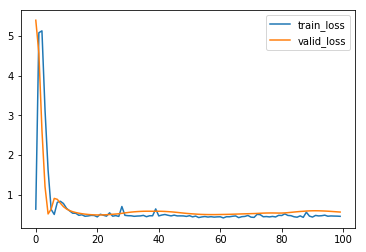

In [27]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

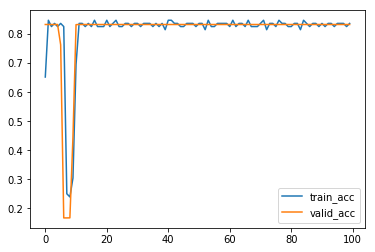

In [28]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()